# K-Means Clustering Demo


In [ ]:
!pip install -r requirements.txt

In [82]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg as la

import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.datasets import load_iris
from sklearn import decomposition
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans as sklearn_kmeans
%matplotlib inline

In [194]:
plt.rcParams["figure.dpi"] = 200

`KMeans` class for doing basic $k$-means clustering.

`__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

`fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.

Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.

`predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$th entry indicates which cluster center the $i$th row of $X$ is closest to.



In [91]:
class KMeans(BaseEstimator, ClusterMixin):
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-5, normalize=False):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize        # This is for Problem 2.
    
    def getClosest(self, X, means):
        
        closest_inx = []
        n, d= X.shape
        for point_inx in range(0, n):
            dist_info = la.norm(X[point_inx] - means,axis=1)
            closest_inx.append(np.argmin(dist_info))
        return np.array(closest_inx)
    
    def getPartition(self, X, means):
        #get closest index
        assigned_inx = self.getClosest(X, means)

        #get partition
        Ss = dict()

        for mean_inx in range(self.n_clusters):
            point_inx = np.argwhere(assigned_inx==mean_inx)

            if len(point_inx) != 0:
                point_inx = np.argwhere(assigned_inx==mean_inx).T[0]
            else:
                point_inx = [np.inf]

            Ss[mean_inx] = point_inx
        
        return Ss
    
    def calculateNewmean(self, X,Ss):
        
        new_means = []
        
        n, d = X.shape

        for points_inx in Ss.values():
            #we randomly assign new point:
            if points_inx[0] == np.inf:
                new_means.append(X[np.random.randint(n)])
            else:
                points = X[points_inx]
                new_mean = np.mean(points,axis=0)
                
#                 print("new_mean shape",new_mean.shape)
#                 print("points shape",points.shape)

                new_means.append(new_mean)
        if self.normalize == True:
            new_means = normalize(new_means)
        return np.array(new_means)
        
            
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        n, d = X.shape
        #coose n_cluster random data points
        means = np.random.random(size=(self.n_clusters, d))  
        
        Ss = self.getPartition(X, means)
        mean_prev = self.calculateNewmean(X, Ss)
        max_iter = 0
        while(True):
            Ss = self.getPartition(X, mean_prev)
            new_mean = self.calculateNewmean(X, Ss)
            
            if la.norm(new_mean - mean_prev) < self.tol or max_iter > self.max_iter:
                self.X = X
                self.means = new_mean
                self.Ss = Ss
                break
            mean_prev = new_mean
            max_iter += 1
        # / np.linalg.norm(new_mean)
            

        
        print("iteration, max_iter", max_iter)
        
        #raise NotImplementedError("Problem 1 Incomplete")
        return self
    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters for each entry of X.
        """
        return self.getClosest(X, self.means)
    
    def fit_predict(self, X, y=None):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)

# Test1: the iris data set 

This is testing the implemented Kmean after reducing the data to two principal components

iteration, max_iter 4


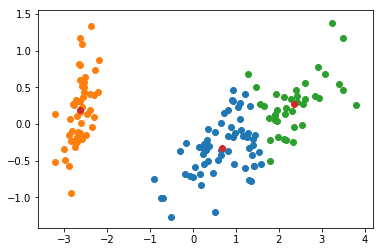

In [92]:
np.random.seed(3)
iris = load_iris()

X = np.array(iris.data)
y = np.array(iris.target)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
kmeans = KMeans()
labels = kmeans.fit_predict(X,y)
plt.scatter(kmeans.X[labels==0].T[0], kmeans.X[labels==0].T[1])
plt.scatter(kmeans.X[labels==1].T[0], kmeans.X[labels==1].T[1])
plt.scatter(kmeans.X[labels==2].T[0], kmeans.X[labels==2].T[1])
plt.scatter(kmeans.means.T[0], kmeans.means.T[1])


# Test 2: Earthquake data

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
Since the data points of lat long are in terms of degrees; I followed the below sequences to plot earthquake data to test the implemented Kmean.

1. Convert longitude and latitude to radians, then to spherical coordinates.
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.


iteration, max_iter 21


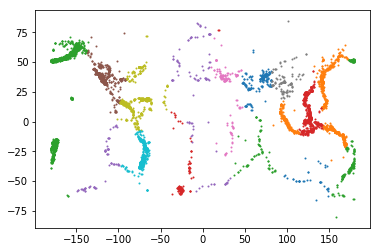

In [107]:
data = np.load("files/earthquake_coordinates.npy")
long,lat = data.T
langitude_rad, laditude_rad = np.pi/180*data.T[0], np.pi/180*(90-data.T[1])

x = np.sin(langitude_rad)*np.cos(laditude_rad)
y = np.sin(langitude_rad)*np.sin(laditude_rad)
z = np.cos(langitude_rad)

X = np.array([x,y,z]).T
kmeans = KMeans(n_clusters=15, normalize=True)
labels = kmeans.fit_predict(X,y)

r = 1
means = kmeans.means

x,y,z = means.T

phi = np.arccos(z)
theta = np.arctan2(y,x)

for c in range(15):
    plt.scatter(long[labels==c], lat[labels==c], s=1)

plt.show()


# Test 3: crab nebula 
In this case, the implemented Kmean was not optmized enough to accomplish this task, therefore, I used sklearn cluster

In [79]:
from sklearn.cluster import KMeans

def quantize_image(img, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    m, n, d = img.shape
    data = img.reshape((-1,3)).copy()
    n_pixel, _ = data.shape
    X = data[np.random.randint(n_pixel, size=50)]
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    means = kmeans.cluster_centers_
    prediction = kmeans.predict(data)
    
    for mean_inx in range(n_clusters):
        inx = prediction == mean_inx
        data[inx] = means[mean_inx]
    reconstructed = np.zeros(shape=(m,n,3))
    reconstructed[:,:,0] = data.T[0].reshape((m,n))
    reconstructed[:,:,1] = data.T[1].reshape((m,n))
    reconstructed[:,:,2] = data.T[2].reshape((m,n))
    return reconstructed


In [80]:
from matplotlib.image import imread
img = imread('files/nasa/crab_nebula.jpg')

In [81]:
q_img = quantize_image(img, n_clusters=4, n_samples=50)


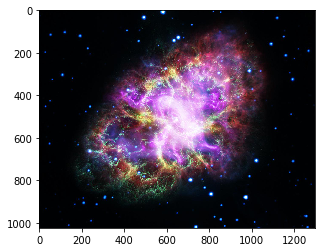

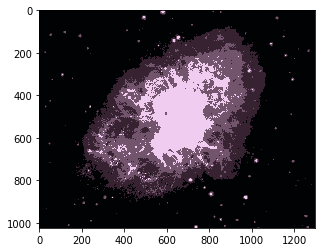

In [82]:
plt.imshow(img)
plt.show()
plt.imshow(q_img.astype(float)/255)
plt.show()